# Classification de locuteur

#### Objectif : créer une chaine de traitement des données textuelles sur la classification de locuteur

#### Jeu de données : citations Chirac Mitterand

* Analyses obligatoires
    * Comparer les performances avec différents pré-traitements
        * e.g Taille de vocabulaire, unigram/bigram, Stemming, ...
    * Implémenter un post-traitement sur les données Chirac/Mitterrand
    * Appliquer les traitements optimaux sur les données de test et sauver les résultats dans un fichier txt

* Compléments optionnels
    * Analyser les performances avec Word2Vec, en utilisant des stratégies d'agrégation naïves

## Import des librairies

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import codecs
import re
import seaborn as sns

In [83]:
path = "data/AFDpresidentutf8/corpus.tache1.learn.utf8"

## Chargement des données Mitterand / Chirac

In [84]:
# Chargement des données:
def load_pres(fname):
    pattern1 = re.compile(r"<[0-9]*:[0-9]*:(.)>.*")
    pattern2 = re.compile(r"<[0-9]*:[0-9]*:.>(.*)")

    with codecs.open(fname, 'r', 'utf-8') as s:
        lines = s.readlines()

    alltxts = [pattern2.sub(r"\1", txt) for txt in lines if len(txt) >= 5]
    alllabs = [-1 if pattern1.sub(r"\1", txt).count('M') > 0 else 1 for txt in lines if len(txt) >= 5]

    return alltxts, alllabs

In [85]:
alltxts,alllabs = load_pres(path)

### Verification de l'équilibre du plan d'expérience

In [69]:
C, M = np.unique(alllabs, return_counts=True)[1]
print(f"Il y a {M/(C+M) * 100} % de citations attribuées à Mitterand et {C/(C+M) * 100} % de citations attribuées à Chirac ")

Il y a 86.89669587027329 % de citations attribuées à Mitterand et 13.103304129726718 % de citations attribuées à Chirac 


On constate que le plan d'expérience n'est pas équilibré. Il va falloir échantilloner notre dataset pour se ramener à une situation à l'équilibre (50% des exemples associés à chaque locuteur).

### Under-sampling dans la classe majoritaire 'Mitterand'

In [97]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

ros = RandomOverSampler(sampling_strategy='auto')
alltxts_res, alllabs_res = ros.fit_resample(np.array(alltxts).reshape(-1, 1), alllabs)

# ou

# smote = SMOTE(sampling_strategy='auto')
# alltxts_res, alllabs_res = smote.fit_resample(np.array(alltxts).reshape(-1, 1), alllabs)

In [98]:
C, M = np.unique(alllabs_res, return_counts=True)[1]
print(f"Il y a {M/(C+M) * 100} % de citations attribuées à Mitterand et {C/(C+M) * 100} % de citations attribuées à Chirac ")

Il y a 50.0 % de citations attribuées à Mitterand et 50.0 % de citations attribuées à Chirac 


L'under sampling a permis le réequilibrage des classes.

In [99]:
# On réassigne les variables pour plus de clarté dans le code
alltxts, alllabs = alltxts_res, alllabs_res

## Analyse des mots fréquents

In [100]:
import nltk
import string

from nltk.util import ngrams
from nltk import FreqDist, word_tokenize
from nltk.corpus import stopwords

# Nécessaire pour la première exécution
nltk.download("punkt")
nltk.download("stopwords") 

# Retire la ponctuation et tokenize
translator = str.maketrans("", "", string.punctuation)
tokens = word_tokenize(" ".join(map(str, alltxts)).translate(translator))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ambroisebertin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ambroisebertin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [101]:
# Filtre les stopwords
stop_words = set(stopwords.words("english"))
tokens = [token for token in tokens if token not in stop_words]

freq_dist = FreqDist(tokens)
vocab_size = len(freq_dist)
print(f"Taille du vocabulaire : {vocab_size}")

Taille du vocabulaire : 46170


In [102]:
# Calcule les 100 bigrammes et trigrams les plus fréquents
bigram_freq = FreqDist(ngrams(tokens, 2))
trigram_freq = FreqDist(ngrams(tokens, 3))

top_100_bigrams = bigram_freq.most_common(100)
top_100_trigrams = trigram_freq.most_common(100)

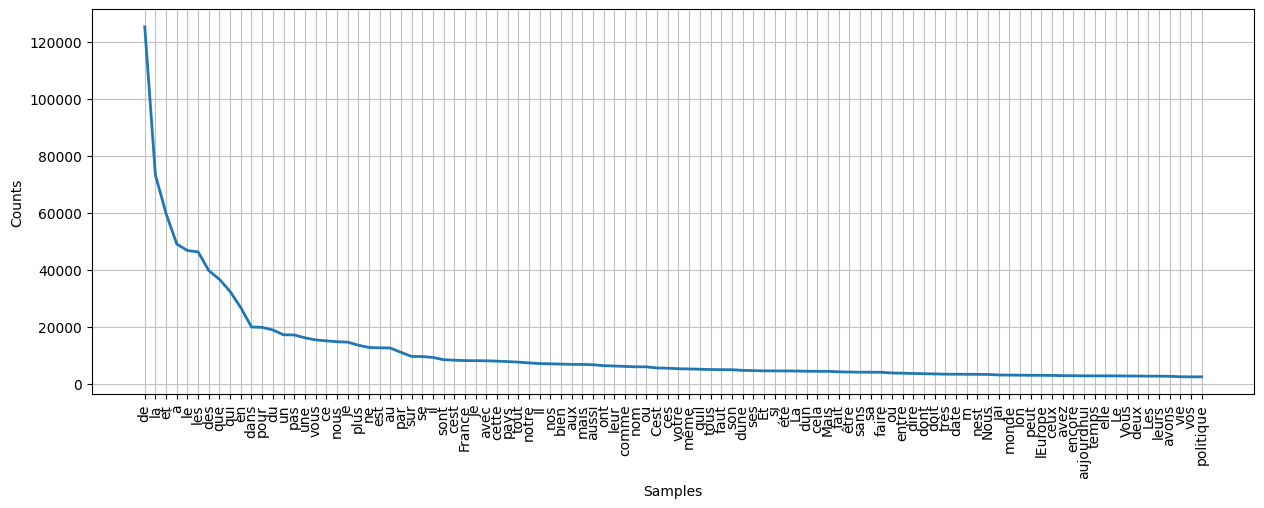

<Figure size 640x480 with 0 Axes>

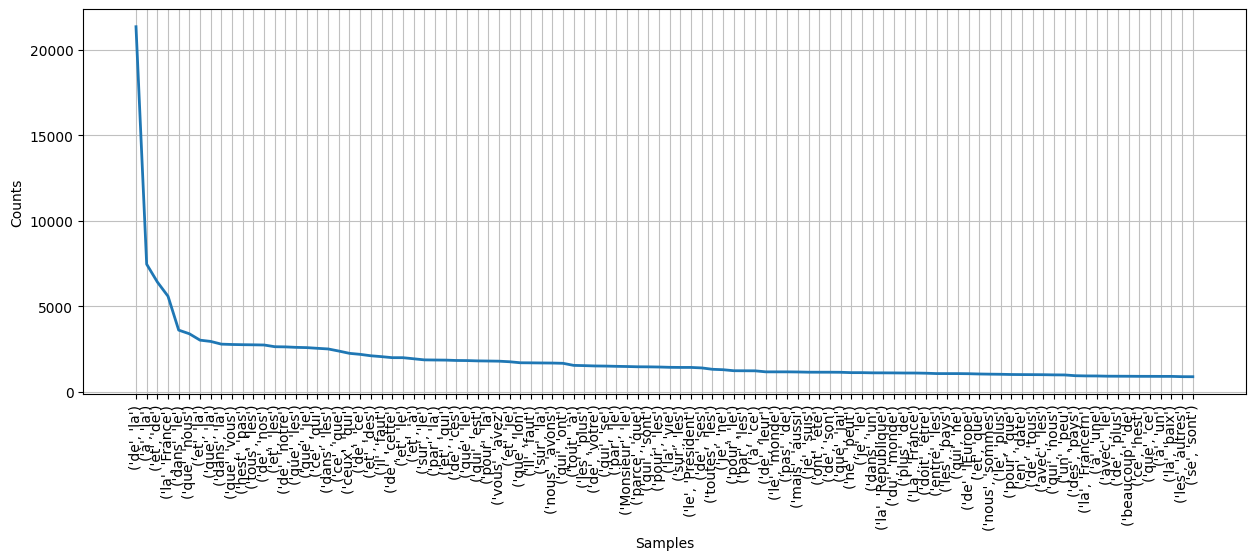

<Figure size 640x480 with 0 Axes>

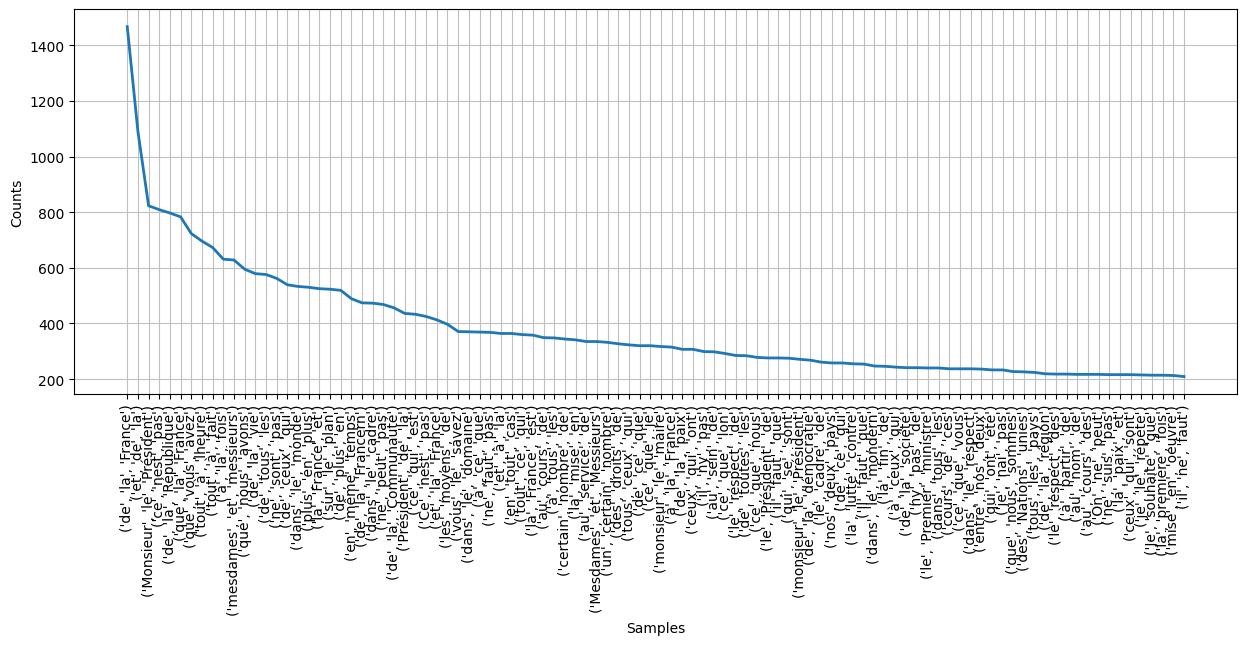

<Figure size 640x480 with 0 Axes>

In [103]:
plt.figure(figsize=(15, 5))
freq_dist.plot(100)
plt.savefig('figures/freq_dist.png')
plt.show()

plt.figure(figsize=(15, 5))
bigram_freq.plot(100)
plt.savefig('figures/bigram_freq.png')
plt.show()

plt.figure(figsize=(15, 5))
trigram_freq.plot(100)
plt.savefig('figures/trigram_freq.png')
plt.show()

## Apprentissage du modèle

### Préparation du dataset pour l'apprentissage

In [104]:
from sklearn.model_selection import train_test_split

# Diviser le dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(alltxts, alllabs, test_size=0.2, random_state=42)

print("Taille de l'ensemble d'entraînement :", len(train_texts))
print("Taille de l'ensemble de test :", len(test_texts))

Taille de l'ensemble d'entraînement : 79824
Taille de l'ensemble de test : 19956


In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

# flatten the list of lists
train_texts_flat = [text for sublist in train_texts for text in sublist]
test_texts_flat = [text for sublist in test_texts for text in sublist]

# Convert the text data into vectors
train_vectors = vectorizer.fit_transform(train_texts_flat)
test_vectors = vectorizer.transform(test_texts_flat)

### Modèle

In [110]:
from sklearn.naive_bayes import MultinomialNB

# Créer le classifieur
clf_NB = MultinomialNB()

# Entraîner le classifieur
clf_NB.fit(train_vectors, train_labels)

# Prédire les labels sur l'ensemble de test
pred = clf_NB.predict(test_vectors)

In [111]:
from sklearn.linear_model import LogisticRegression

# Créer le classifieur
clf_LR = LogisticRegression()

# Entraîner le classifieur
clf_LR.fit(train_vectors, train_labels)

# Prédire les labels sur l'ensemble de test
pred = clf_LR.predict(test_vectors)

/Users/ambroisebertin/miniconda3/envs/general/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [112]:
from xgboost import XGBClassifier

# Créer le classifieur
clf_XGB = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Convert list to Series
train_labels_series = pd.Series(train_labels)

# Map labels from -1,1 to 0,1
train_labels_mapped = train_labels_series.map({-1: 0, 1: 1})

# Train the classifier with the mapped labels
clf_XGB.fit(train_vectors, train_labels_mapped)

# Prédire les labels des données de test
pred = clf_XGB.predict(test_vectors)

In [113]:
from sklearn.svm import LinearSVC

# Créer le classifieur
clf_SVM = LinearSVC(C=1.0)

# Entraîner le classifieur
clf_SVM.fit(train_vectors, train_labels)

# Prédire les labels sur l'ensemble de test
pred = clf_SVM.predict(test_vectors)

/Users/ambroisebertin/miniconda3/envs/general/lib/python3.12/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


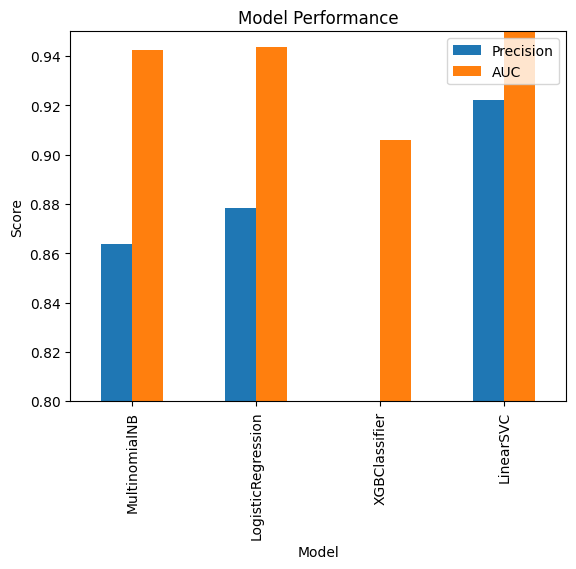

                Model  Precision       AUC
0       MultinomialNB   0.863800  0.942551
1  LogisticRegression   0.878282  0.943795
2       XGBClassifier   0.424033  0.905956
3           LinearSVC   0.922179  0.970272 

Le modèle avec la meilleure précision est LinearSVC
Le modèle avec le meilleur AUC est LinearSVC


In [114]:
from sklearn.metrics import accuracy_score, roc_curve, auc

# on va évaluer chaque modèle avec les métriques "précision" et "AUC"
modele = [clf_NB, clf_LR, clf_XGB, clf_SVM]

# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Precision', 'AUC'])

for model in modele:
    model_name = type(model).__name__
    
    # Calculer la précision
    pred = model.predict(test_vectors)
    precision = accuracy_score(test_labels, pred)

    # Cas particulier pour le modele SVM qui ne possède pas de méthode predict_proba
    if hasattr(model, 'predict_proba'):
        # Calculer l'auc
        pred_proba = model.predict_proba(test_vectors)[:, 1]
    elif hasattr(model, 'decision_function'):  # utiliser decision_function pour le modele SVM qui n'a pas de méthode predict_proba
        pred_proba = model.decision_function(test_vectors)
    else:
        print(f"Le modèle {model_name} n'a pas de méthode pour calculer la probabilité", "\n")
        continue

    fpr, tpr, _ = roc_curve(test_labels, pred_proba)
    roc_auc = auc(fpr, tpr)

    # Ajouter les résultats dans un DataFrame qu'on va ensuite afficher pour synthétiser les résultats
    results.loc[len(results)] = [model_name, precision, roc_auc]

# Afficher les résultats sous forme de graphique
results.plot(kind='bar', x='Model', y=['Precision', 'AUC'])
plt.title('Model Performance')
plt.ylabel('Score')
plt.ylim([0.4, 1])
plt.legend(['Precision', 'AUC'])
plt.show()

# Afficher le tableau de synthèse des résultats
print(results,"\n")

max_precision = results['Precision'].max()
max_auc = results['AUC'].max()

# Indiquer quels sont les modèles qui ont la meilleure précision et le meilleur AUC
best_precision_models = results[results['Precision'] == max_precision]['Model'].values
best_auc_models = results[results['AUC'] == max_auc]['Model'].values

print(f"Le modèle avec la meilleure précision est {', '.join(best_precision_models)}")
print(f"Le modèle avec le meilleur AUC est {', '.join(best_auc_models)}")
